<a href="https://colab.research.google.com/github/ttya16/NaturalLanguageProcessing-zeroDL2/blob/master/NaturalLanguageProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 自然言語処理(Natural Language Processing)
自然言語を処理する分野＝私たちが普段使っている言葉をコンピューターに理解させるための技術

### コンピューターが理解する言語
→プログラミング言語、マークアップ言語<br>
・・・これらは記述が一意に解釈できるよう文法が定義されているため、機械的で無機質なものと言える。



### 自然言語
→日本語、英語など普段私たち人間が使っている言語

・・・これらは同じ記述でも異なる意味をもつ可能性があったり、同じ意味でも表現方法が何通りもあったりと、柔軟性を併せ持ったものと言える。
時代と共に新たな言葉が加わったり、従来の意味が変化したりという性質もある。


コンピューターが自然言語を理解できるようになれば、もっと人にとって役立つことを行わせることができるようになる。<br>
例.機械翻訳、文章の自動要約、感情分析


## 単語の意味
コンピューターに単語の意味を理解させるにはどうすれば良いか。<br>
↓<br>
従来の３つの手法
* シソーラス 
* カウントベース
* 推論ベース(word2vec)


### シソーラス
類語辞書のようなもの。同じ意味or似た意味の単語は同じグループに分類されている。<br>
(自然言語処理において利用されるシソーラスでは単語間に上下関係や包含関係といった細かい関係性が設定されているケースもある)

ex. car = auto automobile machine motorcar 

シソーラスの代表的なもの　＝　WordNet　　
NLTKというモジュールをインストールして使うことができる。

#### 欠点
* 時代の変化に伴う、新単語の追加や単語の意味の変遷に対応するのが困難
* シソーラスを作成するには手間が膨大にかかる
* 単語の意味は捉えられても、それぞれの単語が持つニュアンスまでは捉えられない

### カウントベースの手法
コーパスの準備・・・カウントベース手法による単語の意味表現を行うために、まずは解析のために収集されたテキストデータ（=コーパス）を用意する。

In [0]:
sample_text = "You say goodbye and I say hello."

In [0]:
text = sample_text.lower() #全部小文字で統一する
text = text.replace(".", " .") #最後のピリオドは単体で分けて捉える。

words = text.split(' ') #スペース区切りで単語リストを取得
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [0]:
import numpy as np

#単語にIDを振って、処理しやすい形にする
#word_to_id : 単語からIDを参照するdict
#id_to_word：IDから単語を参照するdict
#corpus：単語IDのリスト
def preprocess(text):
    text = text.lower()
    text = text.replace(".", " .")
    words = text.split(' ')
    
    w_to_id = {}
    id_to_w = {}
    new_id = 0
    for w in words:
        if w not in w_to_id:
            w_to_id[w] = new_id
            id_to_w[new_id] = w
            new_id += 1
            
    corpus = np.array([w_to_id[word] for word in words])
        
    return corpus, w_to_id, id_to_w

In [0]:
corpus, word_to_id, id_to_word = preprocess(sample_text)

In [0]:
print(word_to_id)
print(id_to_word)
print(corpus)

{'hello': 5, 'say': 1, '.': 6, 'you': 0, 'and': 3, 'goodbye': 2, 'i': 4}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
[0 1 2 3 4 1 5 6]


### 単語の分散表現
簡単に言えば、単語の意味をベクトルで表すこと。<br>例えば色はRGBの各成分がどれくらい混ぜ合わさっているかを(R, G, B) = (201, 23, 30)のように表現することができる。<br>これと似たようなことを単語に対しても行えないか、という発想。

#### 分布仮説
「単語の意味は周囲の単語によって形成される」というもので、単語をベクトル表現するという手法の根底にある仮説である。<br>
テキスト中の注目したい単語の周囲にある単語のことを**コンテキスト**と呼び、コンテキストのサイズとは前後の何単語くらいを含めるかを表す。

#### 共起行列
テキスト中の各単語のコンテキストをカウントして、行列で表現したもの。

In [0]:
#テキストから共起行列を作成する関数

def co_occurence(text, window_size=1):
    corpus, word_to_id, id_to_word =preprocess(text)
    mat_size = len(word_to_id)
    C = np.zeros((mat_size, mat_size))
    
    for i in range(len(corpus)):
        for j in range(window_size):
            if i - j - 1  >= 0:
                C[corpus[i] , corpus[i - j -1 ]] += 1
            if i + j + 1 <= len(corpus) - 1:
                C[corpus[i], corpus[i + j + 1]] += 1
    
    C = np.array(C, dtype=np.int32)
    return C

In [0]:
co_occurence(sample_text, window_size=2)

array([[0, 1, 1, 0, 0, 0, 0],
       [1, 0, 1, 2, 1, 1, 1],
       [1, 1, 0, 1, 1, 0, 0],
       [0, 2, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 1, 0]], dtype=int32)

### ベクトル間の類似度
テキスト中の単語のベクトル表現が共起行列によって可能になったら、次は単語間の類似度を測る指標が必要になる。
単純にユークリッド距離や内積を求めるのも良いが、単語の類似度は**コサイン類似度**が主に用いられる。

In [0]:
#cosine similarity
#eps:ゼロ除算を防ぐための微小な値
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    
    return np.dot(nx, ny)

In [0]:
C = co_occurence(sample_text)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]

print(cos_similarity(c0, c1)) #テキスト中の"you"という単語と"i"という単語の類似度がでる

0.7071067691154799


## 類似単語のランキング表示
類似度計算の関数を使って、単語の類似度ランキングを返す関数を用意してみる。

In [0]:
#query: 単語のクエリ
#word_to_id : 単語からIDを参照するdict
#id_to_word：　IDから単語を参照するdict
#word_matrix:　単語ベクトルをまとめた行列。各行に対応する単語のベクトルが格納されている。

def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    #take out the query
    if query not in word_to_id:
        print("%s is not found in database." %query)
        return
    
    print('\n[query]' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    #cosine similarity
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(query_vec, word_matrix[i])
        
    #sort as the highest similarity values
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
            
        print('%s : %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return
    
    
    
    
    

In [0]:
text = "A true leader has a confidence to stand alone, a courage to make tough decisions and a compassion to listen to the needs of others."
corpus, word_to_id, id_to_word = preprocess(text)
C = co_occurence(text)
vocab_size = len(word_to_id)

most_similar('stand', word_to_id, id_to_word, C, top=5)


[query]stand
listen : 0.7071067726510136
make : 0.49999999292893216
the : 0.49999999292893216
compassion : 0.49999999292893216
confidence : 0.49999999292893216


## 相互情報量
共起行列では２つの単語が共起した回数に注目しているが、それだと不十分。<br>なぜなら、"the"や"a"といった高頻出単語の影響で単語同士の関連性が見えづらくなることがある。<br>
例. driveとcarは関連性が強いはずだが、それよりも"the car"という並びでの出現回数が多いため、こちらの方が関連性では強いことになってしまう。


そこで新たに**相互情報量(Pointwise Mutual Information)**という指標を考える。

$$
PMI(x, y) = \log{_2}\frac{P(x, y)}{P(x)P(y)}
$$

P(x, y) :　x, yが同時に起きる確率。ここでは共起する確率を表す。

相互情報量によって２単語の共起回数に加え、各単語の出現回数を考慮することができるようになるため、高頻出単語に対しても正確な指標となって現れる。

※共起回数が0の場合、PMIは-∞の値を取ってしまうため実装の際は正の相互情報量を用いるなどの工夫が必要。

In [0]:
#Positive PMI
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
                    
    return M
    

In [0]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
C = co_occurence(text, 3)
vocab_size = len(word_to_id)
print(np.sum(C, axis=0))
print(np.sum(C))
print(C)
print(ppmi(C))

[3 9 5 6 6 4 3]
36
[[0 1 1 1 0 0 0]
 [1 0 2 2 2 1 1]
 [1 2 0 1 1 0 0]
 [1 2 1 0 1 1 0]
 [0 2 1 1 0 1 1]
 [0 1 0 1 1 0 1]
 [0 1 0 0 1 1 0]]
[[0.0000000e+00 4.1503751e-01 1.2630345e+00 1.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [4.1503751e-01 0.0000000e+00 6.7807192e-01 4.1503751e-01 4.1503751e-01
  1.4426950e-08 4.1503751e-01]
 [1.2630345e+00 6.7807192e-01 0.0000000e+00 2.6303440e-01 2.6303440e-01
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 4.1503751e-01 2.6303440e-01 0.0000000e+00 1.4426950e-08
  5.8496249e-01 0.0000000e+00]
 [0.0000000e+00 4.1503751e-01 2.6303440e-01 1.4426950e-08 0.0000000e+00
  5.8496249e-01 1.0000000e+00]
 [0.0000000e+00 1.4426950e-08 0.0000000e+00 5.8496249e-01 5.8496249e-01
  0.0000000e+00 1.5849625e+00]
 [0.0000000e+00 4.1503751e-01 0.0000000e+00 0.0000000e+00 1.0000000e+00
  1.5849625e+00 0.0000000e+00]]


## 次元削減
共起行列やPPMI行列は語彙数が増えるとそのサイズも大きくなり、かつその要素のほとんどが0である（疎行列）。<br>
このようなベクトルはノイズの影響を受けやすく、頑健性に乏しい。<br>
そこでベクトルの次元を削減することを考えるのだが、**重要な情報はできる限り残す**ことがポイント。<br>代表的な手法として特異値分解がある。
<br>
* 特異値分解(SVD)
$$
X = USV^T
(U, V : 直交行列　　  S : 対角行列)
$$

np.linalg.svdでSVDの計算が可能。<br>
しかしSVDの計算は$O(n^3)$になる為、大きいサイズの行列を扱う場合は注意。<br>
例えばTruncated SVD(特異値の小さいものは省いて計算)を用いたりして工夫する必要がある。

In [0]:
#SVD
import numpy as np
import matplotlib.pyplot as plt

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
C = co_occurence(text)
W = ppmi(C)

U, S, V = np.linalg.svd(W)
print(U.shape)

(7, 7)


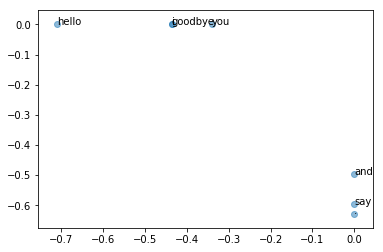

In [0]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

## PTBデータセットでの評価

ここまではサンプルテキストから生成した非常に小さなコーパスを用いてきたが、より大きな本格的なコーパスを用いてみる。<br>
Penn Treebankコーパスは適度な大きさのコーパスで、ベンチマーク用にも適している。

[ゼロから始めるディープラーニング2のGitHubのptb.py]("https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/dataset/ptb.py")によってPTBデータセットをダウンロード。

In [0]:
!ls

LICENSE.md                      ch05
NaturalLanguageProcessing.ipynb ch06
README.md                       ch07
ch01                            ch08
ch02                            common
ch03                            dataset
ch04


In [0]:
#Penn Treebankデータセット
import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

Done


In [0]:
def co_occurence_fromcorpus(corpus, vocab_size, window_size=1):
    C = np.zeros((vocab_size, vocab_size))
    
    for i in range(len(corpus)):
        for j in range(window_size):
            if i - j - 1  >= 0:
                C[corpus[i] , corpus[i - j -1 ]] += 1
            if i + j + 1 <= len(corpus) - 1:
                C[corpus[i], corpus[i + j + 1]] += 1
    
    C = np.array(C, dtype=np.int32)
    return C

C = co_occurence_fromcorpus(corpus, len(word_to_id))

In [0]:
W = ppmi(C)

In [0]:
from sklearn.utils.extmath import randomized_svd

U, S, V = randomized_svd(W, n_components=100, n_iter=5, random_state = None)

## 推論ベースの手法

単語をベクトルで表現する方法としてもう一つ挙げられるものとして、**推論ベースの手法**がある。<br>
カウントベース手法とはアプローチの仕方が異なるが、いずれも分布仮説に基づいた手法となっている。

### 推論ベース手法の概要
以下のようなテキストの"？"の部分にどの単語が来るかという「推論」を行う。<br>

**you ? goodbye and I say hello.**<br>
前後にある単語から？にはどういう単語が当てはまるかを、単語の出現パターンを学習することで推測できるようなモデルを考える。<br>
モデルとしてはニューラルネットを用いる。


#### カウントベース手法の問題点
カウントベース手法では、単語の共起行列（→PPMI行列）を作り、SVDを用いて次元削減を行い、単語の分散表現を獲得するという流れだった。<br>
ところが大規模なコーパス(語彙数100万など)を扱うとなると、100万×100万サイズの行列に対してSVDを実行しなければならない。<br>
SVDは入力サイズn×n行列に対して計算量がO(n^3)とかかる為、n=100万の場合は現実的ではないことは明らかである。

## one-hot vector
単語をそのままニューラルネットに処理させることはできないので、ここでもまたベクトル表現に変換してあげる必要がある。<br>
ニューラルネットの場合は固定長のベクトルに変換する必要がある為、**one-hot表現**によるベクトル変換がよく用いられる。

$$
\left[\begin{array}{c}
you(id=0)\\
goodbye(id=2)\\
\end{array}\right]  =
\left[\begin{array}{c}
1&0&0&0&0&0&0\\
0&0&1&0&0&0&0\\
\end{array}\right]
$$

one-hot vector表現では単語IDの該当する箇所に1を、残りは0を設定する。<br>


In [0]:
"""one-hot vector表現の単語をNNの全結合層によって変換するイメージ例"""

import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) #input
w = np.random.randn(7, 3) #weight
h = np.dot(c, w) #hidden layer node
print(h)

[[ 0.0877564  -0.05846083 -0.12946881]]


上で行なっているのは、**ID=0の単語に対する重みの行ベクトルを抜き出す**という処理に他ならない。<br>
わざわざ重みの行ベクトルを抜き出すためだけに行列計算をするのは効率が悪いと感じられる。→改良の余地あり

## シンプルなword2vec

コンテキスト　→　モデル　→　確率分布<br>
この流れで推論ベースの単語ベクトルを作成するが、このモデルをNNで設計していく。

### CBOW(contiuous bag-of-words)
コンテキストからターゲット（コンテキストに対する中央の単語）を推測することを目的としたNN。


In [0]:
#NNの準備　MatMul layer

class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
        
    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out
    
    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dw = np.dot(self.x.T, dout)
        self.grads[0][...] = dw
        return dx


In [0]:
#CBOW

#sample context data
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

#initialize weight matrix
W_in = np.random.randn(7, 3)
W_out = np. random.randn(3, 7)

#layers
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

#feed forward
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5*(h0 + h1)
s = out_layer.forward(h)

print(s)


[[-1.68594431 -0.40587038  0.92271091  0.43235151  0.3998735  -0.378036
   1.05701179]]


上のシンプルCBOWの例では出力として各単語のスコアが算出されており、これに対してsoftmax関数を適用させてやれば確率を得ることができる。

### CBOWモデルの学習
* word2vecモデルの学習の目標は、**コンテキスト（入力）を元に、コンテキストの中心に来るべきターゲット（出力）の出現確率を最大にする**ことである。
* 学習されるのは重みW_in, W_outだが、これらがまさに単語の出現パターンを捉えたmatrixとなる。

### 学習データの準備
サンプルのコーパスとしては以降もこれまでと同様に"You say goodbye and I say hello."の１文をコーパスとして利用する。
#### コンテキストとターゲット
コーパスからコンテキストとターゲットを作成する。

In [0]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [0]:
#create contexts and target
#not considering the edge words here
def create_contexts_target(corpus, window_size=1):
    contexts = []
    target = corpus[window_size : -window_size]
    
    for i in range(window_size, len(corpus) - window_size):
        cs = []
        for s in range(-window_size, window_size + 1):
            if s == 0:
                continue
            cs.append(corpus[i + s])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

c, t = create_contexts_target(corpus)
print(c.shape)
print(t.shape)

(6, 2)
(6,)


In [0]:
#converting contexts and target to one-hot vector representation
def one_hot_encoding(target, vocab_size):
    I = np.identity(vocab_size)
    
    return I[target]

In [0]:
vocab_size = len(word_to_id)
t_ohe = one_hot_encoding(t, vocab_size)
c_ohe = one_hot_encoding(c, vocab_size)
print(c_ohe[:,0])

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]


In [0]:
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        #重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01*np.random.randn(H, V).astype('f')
        
        #layers
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        #全ての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        #メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in
    
    #feed forward    
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        
        return loss
    
    #backprop
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

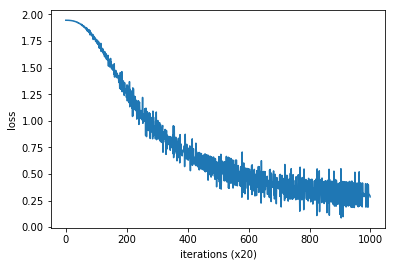

In [0]:
from common.trainer import Trainer
from common.optimizer import Adam

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size=window_size)
target = one_hot_encoding(target, vocab_size)
contexts = one_hot_encoding(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

### word2vecに関する補足
CBOWモデルはコンテキストが与えられた上で、ターゲットとなる単語の確率を出力する。<br>
今ウィンドウサイズ1のモデルを考えた時、コンテキスト$w_{t-1},w_{t+1}$に対してターゲットtが得られる確率は事後確率の表記で以下のように表せる。

$$P(w_{t}|w_{t-1}, w_{t+1})$$

CBOWはまさにこの事後確率をモデル化していると言える。<br>
交差エントロピー誤差$$L = -\sum_k t_k \log{y_k}$$を当てはめてやる。
(t_kは教師ラベルでone-hotベクトル)

するとコンテキストが$w_{t-1}$、$w_{t+1}$の時のCBOWモデルの出力に対する誤差は、
$$L = - \log{P(w_t | w_{t-1}, w_{t+1})}$$
と書ける。

コーパス全体に拡張すると、損失関数として以下のように表現できる。
$$L = -\frac{1}{T}\sum_{t=1}^{T} \log{P(w_t|w_{t-1}, w_{t+1})}$$

## skip-gramモデル
word2vecで提案されているもう一つのモデル。<br>
CBOWとは逆に中央の単語（ターゲット）から周囲の単語（コンテキスト）を推定するモデル。

確率表記で示すと、「$w_t$が与えられた時の$w_{t-1}, w_{t+1}$が**同時に起こる**確率」を求めることになり、
$$P(w_{t-1}, w_{t+1}|w_t)$$
となる。<br>

なお、ここではコンテキストの単語間には関連性がないと仮定する（＝条件付き独立であると仮定する）。<br>
したがって、
$$P(w_{t-1}, w_{t+1}|w_t) = P(w_{t-1}|w_t)P(w_{t+1}|w_t)$$
と分解できる。

交差エントロピー誤差に適用すると、
$$
\begin{align}
L &= -\log{P(w_{t-1}, w_{t+1}|w_t)}\\&= -\log{P(w_{t-1}|w_t)P(w_{t+1}|w_t)}\\&= -(\log{P(w_{t-1}|w_t)} + \log{P(w_{t+1}|w_t)})
\end{align}
$$

コーパス全体に拡張すると、
$$L = -\frac{1}{T}\sum_{t=1}^{T} (\log{P(w_{t-1}|w_t)} + \log{P(w_{t+1}|w_t))}$$


skip-gramはコンテキストの数だけ推測を行うため、損失関数は各コンテキストで求めた損失の総和となる。

### CBOW vs skip-gram
* 精度の点においてはskip-gramの方が優秀
* 学習速度はCBOWの方が速い

# まとめ
## カウントベース vs 推論ベース
* カウントベース：コーパス全体の統計データから1回の処理（共起行列(ppmi)→SVD）で単語の分散表現を獲得する手法。
* 推論ベース：コーパスを部分的に見ていき、学習しながら単語の分散表現を得ようとする手法。
* カウントベースの欠点としては、新たな単語を追加するときには分散表現を1から計算し直して更新する必要がある。
* 推論ベースでは学習済みのモデルに新たな単語の情報を追加して再学習させることで分散表現を更新できるため、カウントベースに比べて楽。
* 推論ベースの方が単語間の複雑な関係性も捉えることが可能だが、単語間の類似性という点においてはカウントベースと大差ない精度。
* ある条件下ではそれぞれの手法は同値であることも分かっている。(skip-gram & negative-sampling)
* GloVeというカウントベースと推論ベースをmixした手法も提案されている。